## The application

The application uses a variety of NLP techniques, including sentiment analysis, word frequency analysis, word trends over time and aspect based sentiment analysis.

The Playground section is a sandbox where users can experiment with the NLP models that are used by the tool. This section allows users to try out different features of the models, to see how they work, and to learn more about how NLP can be used to analyze TripAdvisor reviews.

We use `selenium` package to scrape reviews from a TripAdvisor hotel page, `nltk` to tokenize and pre-processing text data and hugging face's `transformers` package for pre-trained models.

## Background

Text mining is the process of extracting information and insights from text. It can be used to identify patterns, trends, and sentiment in large amounts of text data.

For the purpose of this article we're gonna explore how text mining can be an evalutation tool for Hotel owners in order to understand customer's feelings and toughts.

For the sake of clarity we're gonna focus on two of many techniques used in the application:

- Bigrams analysis
- Word trends analysis


## Bigrams analysis

> A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for $n=2$.
>
> <cite>[Wikipedia](https://en.wikipedia.org/wiki/Bigram)</cite>

When we talk about bigrams we may be interested in visualizing all of the relationships among words simultaneously, rather than just the top few at a time. 

As one common visualization, we can arrange the words into a network, or *“graph”*. Here we’ll be referring to a *“graph”* not in the sense of a visualization, but as a combination of connected nodes.
A graph is composed of three main components:

- **from**: the node an edge is coming from
- **to**: the node an edge is going towards
- **weight**: A numeric value associated with each edge

::: callout-tip
Note that this is a visualization of a **Markov chain**, a common model in text processing. In a Markov chain, each choice of word depends only on the previous word. So in this case the chain starting from **"hotel"** would suggest **"staff"** then **"friendly/helpful"** as next words, by following each word to the most common words that follow it.   ^[[Julia Silge, David Robinson; Text Mining with R; O'Reilly](https://www.tidytextmining.com/ngrams)]
:::

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from plotnine import *

def words_network_graph(dataset,
                        tuple,
                        raw,
                        frequency):
    
    # read data
    data = pd.read_csv(dataset)   
    def tupler(w):
        return (w.split(' ')[0],w.split(' ')[1]) # <1>
    data[tuple] = data[raw].apply(lambda x: tupler(x)) 
    data = data[data['frequency']>=frequency]

    # create dictionary with counts
    d = data.set_index(tuple).T.to_dict('records')

    # network graph
    G = nx.Graph()

    # edges connections
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v*30))

    # nodes position
    pos = nx.spring_layout(G,k=2)

    # edges weight
    weights = nx.get_edge_attributes(G, 'weight').values()
    weights = list(weights)
    weights = list([w*0.0060 for w in weights])
    
    # plot
    
    blue_munsell = '#0085A1'
    eerie_black = '#242728'
    
    fig, ax = plt.subplots(figsize=(7,5))
    fig.set_facecolor(eerie_black)
    ax.set_axis_off()
    
    nx.draw_networkx(G, pos,
                     width=weights,
                     edge_color='white',
                     node_color=blue_munsell,
                     with_labels=False,
                     ax=ax,
                     node_size=50)
    
    # labels nudge
    def nudge(pos, x_shift, y_shift):
        return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()} # <2>
    pos_nodes = nudge(pos, 0.01, 0.1)
    nx.draw_networkx_labels(G, 
                            pos=pos_nodes, 
                            ax=ax,
                            font_color='white',
                            font_size=7)

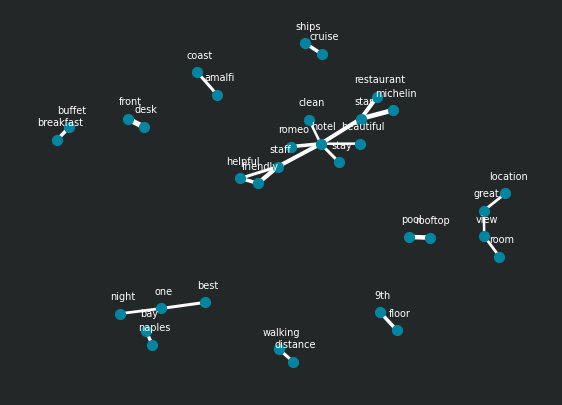

In [2]:
words_network_graph('reviews_bigrams.csv',
                    'bigram',
                    'bigrams',
                    10)

## Word trends over time

When talking about hotel reviews, we need to consider the time view of the customer experience.

From the owner perspective we may want to answer to questions like:

1. How much a product/service is mentioned in customers reviews?
2. How the product/service mention is changing over time?

This could give us a sense of the hotel changing ecosystem.

Let's define

$x= \text{number of occurrences of a word in a token list}$


$n= \text{total number of tokens in a list}$


We can calculate

$$
frequency = \frac{x}{n}
$$

Let’s compare a couple of common words such as *service* and *food*.

::: callout-tip
The frequency of a word on tokens list length is calculated over a list of tokens without stopwords.
:::

In [3]:
def words_overtime_chart(words_list):
    
    # read data
    data = pd.read_csv('data.csv')
    # tokens list by review date
    wot = data.groupby('review_date', as_index=False)['tokens'].sum()
    # frequency of words on tokens length
    for word in words_list:
        wot[word] = wot['tokens'].apply(lambda x: x.count(word)/len(x))
        
    # appending review_date for melt    
    words_list.append('review_date')
    wot = wot[words_list].melt(id_vars=['review_date'], var_name='words', value_name='value')
    
    wot['value'] = wot['value']*100
    
    # plot # <1>
    
    blue_munsell = '#0085A1'
    eerie_black = '#242728'
    
    pl = (
        ggplot(wot) 
        + aes(x='review_date',y='value',group=1)
        + geom_point(color='white')
        + geom_line(colour=blue_munsell,size=1)
        + geom_smooth(method='lm',colour='white')
        + facet_wrap('~words',ncol=1)
        + scale_x_date(date_labels = "%b %Y")
        # dark-theme for plotnine plots 
        + theme(figure_size=(8.0,5.5),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank(),
                axis_line=element_line(color='#5a5856'),
                axis_ticks=element_line(color='#eaeaea'),
                axis_text_x=element_text(angle=75,size=8),
                axis_text_y=element_text(color='#eaeaea',size=8),
                axis_title_x=element_text(color='#eaeaea',size=9),
                axis_title_y=element_text(color='#eaeaea',size=9),
                strip_text=element_text(size=9),
                strip_background=element_rect(fill='#0085A1'),
                panel_background=element_rect(fill='#242728'),
                plot_background=element_rect(fill='#242728'),
                text=element_text(color='#eaeaea',size=12)
                )
        + xlab('Review date')
        + ylab('Frequency (%)')

        )
    
    print(pl)

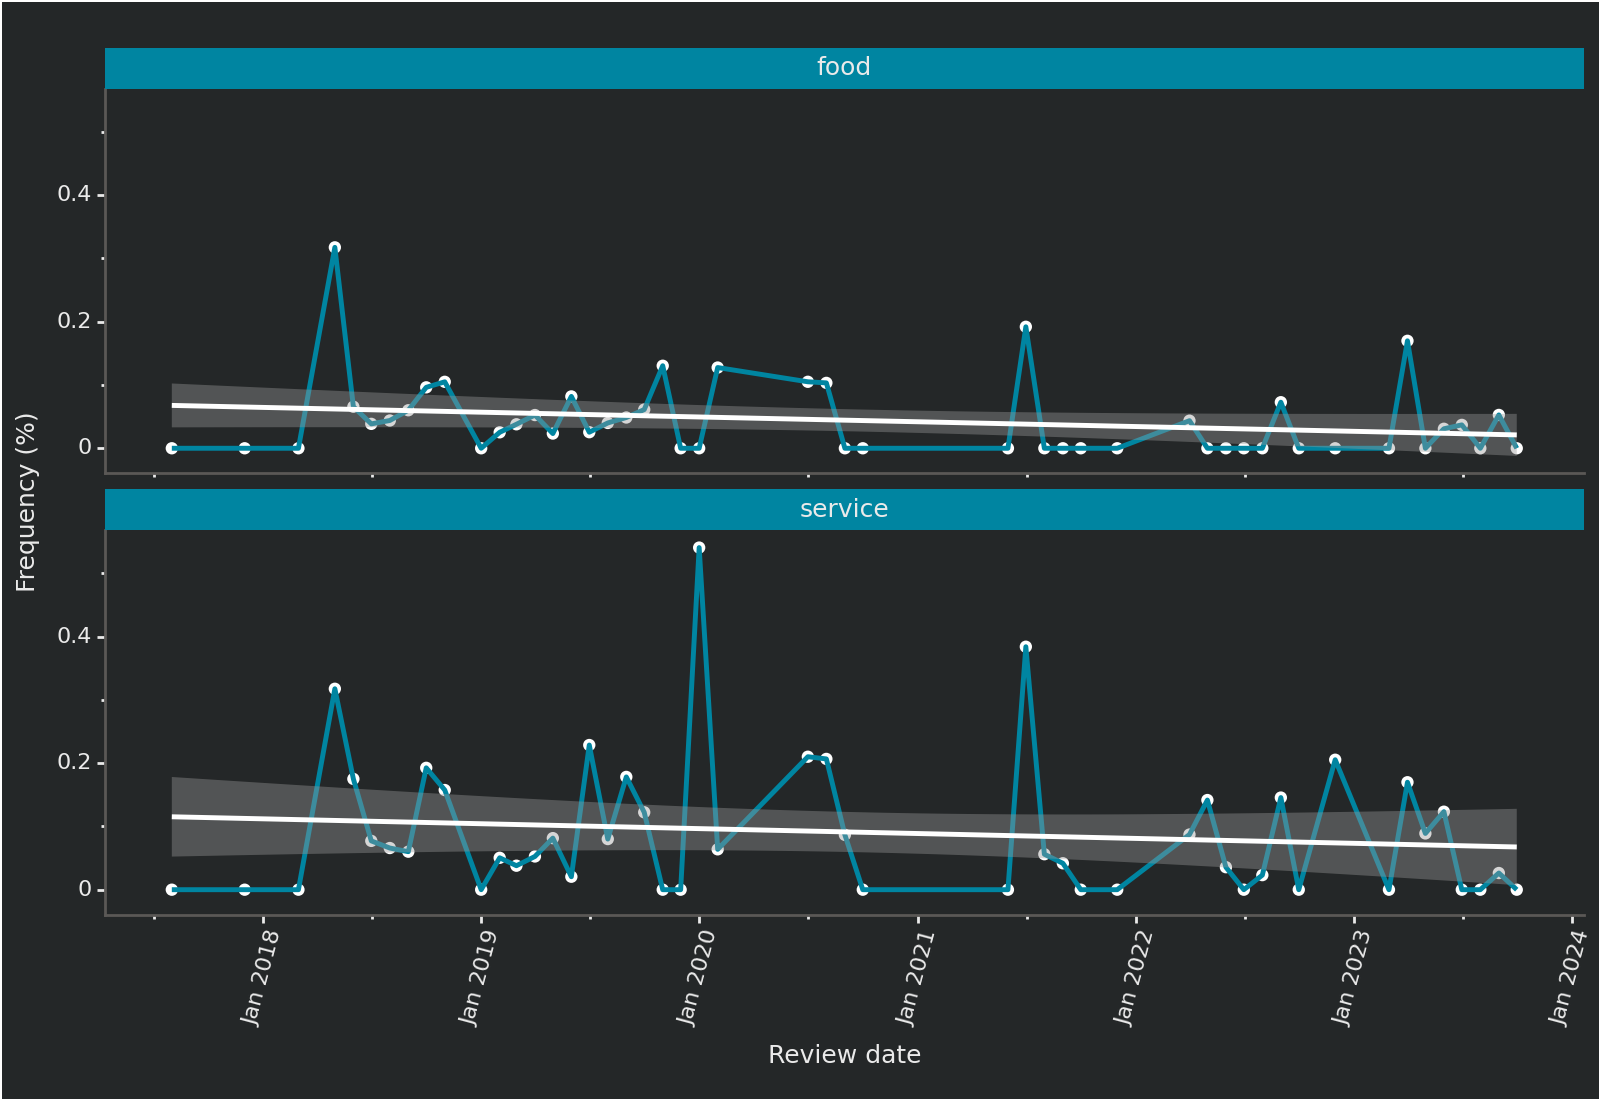

In [4]:
words_overtime_chart(['food','service'])

- The conversation about *food* peaked in 2018 for then following a downward trend.
- The conversation about *service* instead seems to have a more seasonal trend within an overall downward trend.

## Conclusions

As just an NLP exercise this article aim to show potentiality of text mining for business purposes, as well as it could be a powerful tool to gather insights on a product or a service.